# **Convolutional vs. Fully Connected Neural Networks**

# Introduction
In this assignment, we will compare fully connected neural networks with convolutional neural networks to evaluate whether convolutional architectures offer superior performance—and understand the reasons behind any observed differences.

## Device

In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Dataset

## Transforms & Dataset & Dataloader

In [2]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
])

In [4]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torchvision

batch_size = 512

initial_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainset, valset = random_split(initial_trainset, [45000, 5000])

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False)
valloader = DataLoader(valset, batch_size=batch_size)
testloader = DataLoader(testset, batch_size=batch_size)

100%|██████████| 170M/170M [00:13<00:00, 12.7MB/s]


### Why Do We Convert a `Dataset` to a `DataLoader`?

The `Dataset` class in PyTorch provides a way to **organize and access data** through indexing, but on its own, it lacks essential features needed for efficient training of machine learning models. The `DataLoader` wraps a `Dataset` and provides critical functionality that makes the training process smoother and more performant.

### Advantages of `DataLoader` Over `Dataset`:

1. **Automatic Batching**

    * DataLoader splits the data into mini-batches (e.g., `batch_size=512`), which is necessary for training neural networks efficiently.
    * Without it, you would have to manually index and stack batches during training.

2. **Shuffling**

    * DataLoader can automatically shuffle the data at each epoch (`shuffle=True`), which helps prevent the model from learning the order of the data and improves generalization.
    * Dataset does not support shuffling.

3. **Parallel Data Loading**

    * DataLoader supports loading data in parallel using multiple subprocesses (`num_workers > 0`), significantly speeding up training when dealing with large datasets or expensive preprocessing.
    * Dataset is single-threaded by default.

4. **Memory Efficiency**

    * DataLoader loads only a batch at a time, which is more memory-efficient compared to trying to load the full dataset manually.


While the Dataset defines how to access and preprocess data, the DataLoader makes it **practical and efficient** to use that data for training and evaluation by adding batching, shuffling, parallel loading, and iteration capabilities. Therefore, using a DataLoader is a best practice and essential in most deep learning workflows.

## Visualization

We visualize 5 random images from each class in different columns.

In [5]:
import torch

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def __call__(self, tensor, gray=False, coeff=(0.3, 0.59, 0.11)):
        tensor = tensor * self.std + self.mean

        if gray:
            r, g, b = tensor[0], tensor[1], tensor[2]
            gray_tensor = coeff[0] * r + coeff[1] * g + coeff[2] * b
            return gray_tensor.unsqueeze(0)

        return tensor

norminv = UnNormalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261))

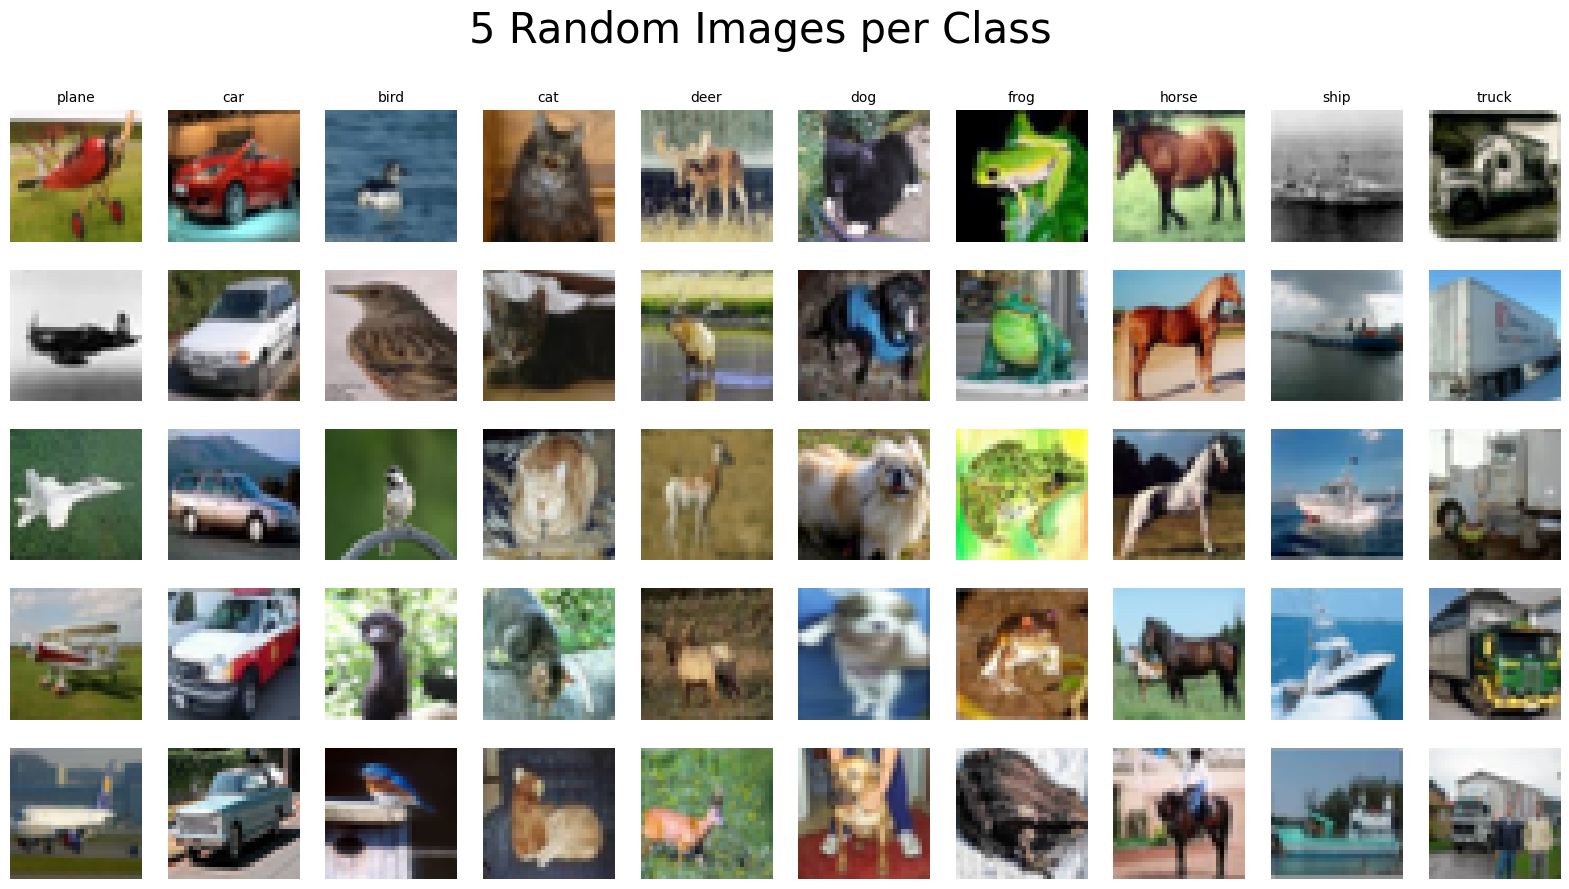

In [6]:
import matplotlib.pyplot as plt
import random

class_images = {i: [] for i in range(10)}

for img, label in initial_trainset:
    if len(class_images[label]) < 10:
        class_images[label].append(img)
    if all(len(imgs) >= 10 for imgs in class_images.values()):
        break

fig, axes = plt.subplots(5, 10, figsize=(20, 10))
fig.suptitle('5 Random Images per Class', fontsize=30)

for col in range(10):
    samples = random.sample(class_images[col], 5)
    for row in range(5):
        img_tensor = norminv(samples[row])
        img_np = img_tensor.permute(1, 2, 0).numpy()

        ax = axes[row, col]
        ax.imshow(img_np)
        ax.axis('off')

        if row == 0:
            ax.set_title(classes[col], fontsize=10)

plt.show()

# Fully Connected Neural Netwrok

Your first task is to build a fully connected neural network with PyTorch. To achieve this, it is recommended that you familiarize yourself with the following PyTorch components and incorporate them into your network architecture:

* [`nn.Module`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html)
* [`nn.Sequential`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
* [`nn.Linear`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)
* [`nn.ReLU`](https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
* [`nn.Dropout`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html)
* [`nn.Flatten`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Flatten.html)

In the provided template below, the final layer of the model should be defined separately and assigned the name `linear`, as it will be referenced in a later section of this assignment.

To ensure a fair comparison with convolutional neural networks (CNNs), both models should have approximately the same number of trainable parameters. Specifically, the fully connected model should contain **33,500,000 ± 500,000** trainable parameters.

You will calculate the exact number of trainable parameters in the following subsection to ensure this requirement is met.




In [7]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
import math
from torchvision import transforms

class FullyConnectedNetwork(nn.Module):
    def __init__(self, input_shape=(3, 32, 32), num_classes=10):
        super(FullyConnectedNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 32 * 32, 5300),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(5300, 2700),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(2700, 1080),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(1080, 512),
            nn.ReLU(),
            nn.Dropout(0.6)
        )
        self.linear = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.network(x)
        pred = self.linear(x)
        return pred

## Trainable params

**Layer-by-Layer Parameter Count**

Each `nn.Linear(in, out)` has:
 `in × out (weights)` + `out (biases)` = `in × out + out`

1. Linear(3072, 5300)

    → 3072 × 5300 + 5300 = 16,281,600 + 5300 = 16,286,900

2. Linear(5300, 2700)

    → 5300 × 2700 + 2700 = 14,310,000 + 2700 = 14,312,700

3. Linear(2700, 1080)

    → 2700 × 1080 + 1080 = 2,916,000 + 1080 = 2,917,080

4. Linear(1080, 512)

    → 1080 × 512 + 512 = 552,960 + 512 = 553,472

5. Linear(512, 10)

    → 512 × 10 + 10 = 5120 + 10 = 5130


**Total Parameters:**
    16,286,900 + 14,312,700 + 2,917,080 + 553,472 + 5,130 = **34,075,282**

Verifying the results:

In [8]:
from torchsummary import summary
summary(FullyConnectedNetwork().to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                 [-1, 5300]      16,286,900
              ReLU-3                 [-1, 5300]               0
           Dropout-4                 [-1, 5300]               0
            Linear-5                 [-1, 2700]      14,312,700
              ReLU-6                 [-1, 2700]               0
           Dropout-7                 [-1, 2700]               0
            Linear-8                 [-1, 1080]       2,917,080
              ReLU-9                 [-1, 1080]               0
          Dropout-10                 [-1, 1080]               0
           Linear-11                  [-1, 512]         553,472
             ReLU-12                  [-1, 512]               0
          Dropout-13                  [-1, 512]               0
           Linear-14                   

## Train

### Model Instantiation

Create an instance of your model and move it to your selected device (CPU or GPU).

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FullyConnectedNetwork(input_shape=(3, 32, 32), num_classes=10).to(device)
print(f"Using device: {device}")

Using device: cuda


### Criterion & Optimizer


To train a neural network, we require a **loss function** (referred to as the *criterion*) to quantify the difference between the model's predictions and the true labels. This loss is then used to compute the gradients of the model parameters.

In addition, an **optimization algorithm** is needed to update the model's parameters using the calculated gradients, in order to minimize the loss over time.

You are encouraged to read about the following PyTorch components:

* [`nn.CrossEntropyLoss`](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
* [`torch.optim.Adam`](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html)

#### **Loss Function: CrossEntropyLoss**
`CrossEntropyLoss` combines **LogSoftmax** and **Negative Log-Likelihood Loss** in one function. It's used for **multi-class classification** problems, where each input belongs to **one of several classes**.

* Why use CrossEntropy for CIFAR-10?
    * CIFAR-10 is a **multi-class classification** task (10 distinct classes).
    * Each input image has **exactly one correct label**.
    * `CrossEntropyLoss` is ideal because it measures the distance between the predicted probability distribution and the true label (as a one-hot vector).
    * It **penalizes incorrect predictions more strongly** when the model is confident but wrong.


#### **Optimizer: Adam**
`Adam (Adaptive Moment Estimation)` is a popular optimization algorithm that combines the benefits of:
* **Momentum** (like in SGD with momentum)
* **Adaptive Learning Rates** (like AdaGrad)

It keeps track of:

* The **exponentially decaying average** of past gradients (1st moment)
* The **exponentially decaying average** of past squared gradients (2nd moment)

It then adjusts the learning rate for each parameter **individually** based on these statistics.

##### Adam vs. SGD
| Feature                | Adam                        | SGD                       |
| ---------------------- | --------------------------- | ------------------------- |
| Learning Rate          | Adaptive per parameter      | Fixed or decayed globally |
| Memory Usage           | Higher (stores moments)     | Lower                     |
| Convergence            | Usually faster              | Slower but more stable    |
| Tunability             | Less sensitive to lr tuning | Requires careful tuning   |
| Generalization (often) | Slightly worse              | Often better              |


In [10]:
learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train loop

Train your model

Tasks:
- Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- save train/validation loss and accuracy (of each epoch) in an array for later usage

In [11]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer, dataloader: torch.utils.data.DataLoader):
    """
    Trains the neural network for a single epoch.

    Args:
        net (torch.nn.Module): The neural network model to be trained.
        criterion (torch.nn.Module): The loss function used to compute the training loss.
        optimizer (torch.optim.Optimizer): The optimization algorithm used to update model parameters.
        dataloader (torch.utils.data.DataLoader): DataLoader providing the training data in batches.

    Returns:
        tuple:
            - avg_loss (float): The average loss across all batches in the epoch.
            - accuracy (float): The classification accuracy (in percentage) over the entire dataset for the epoch.
    """
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    """
    Evaluates the neural network on a validation or test dataset for one epoch.

    Args:
        net (torch.nn.Module): The neural network model to be evaluated.
        criterion (torch.nn.Module): The loss function used to compute the loss.
        dataloader (torch.utils.data.DataLoader): DataLoader providing the validation/test data.
        test_mode (bool): If True, indicates evaluation on test set; otherwise, validation set.

    Returns:
        tuple:
            - avg_loss (float): The average loss across all batches.
            - accuracy (float): The classification accuracy (in percentage) over the dataset.
    """
    net.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy

As previously mentioned, ensuring a fair comparison between models requires consistency in certain aspects of the training setup. One key factor is the number of **trainable parameters**, and another is the number of times the model processes the entire dataset—referred to as an **epoch**.

To maintain consistency in training duration across models, we **do not modify** the `epochs` variable defined below.


In [12]:
epochs = 50

history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}


for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, criterion, optimizer, trainloader)
    val_loss, val_acc = eval_epoch(model, criterion, valloader)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"(Epoch {epoch + 1} / {epochs}) train loss:{train_loss: .4f}; train acc:{train_acc: .2f}%; val loss:{val_loss: .4f}; val_acc:{val_acc: .2f}%")

(Epoch 1 / 50) train loss: 2.0762; train acc: 23.17%; val loss: 1.8241; val_acc: 34.10%
(Epoch 2 / 50) train loss: 1.8158; train acc: 34.32%; val loss: 1.6767; val_acc: 39.64%
(Epoch 3 / 50) train loss: 1.7091; train acc: 38.89%; val loss: 1.6036; val_acc: 42.36%
(Epoch 4 / 50) train loss: 1.6393; train acc: 42.06%; val loss: 1.5461; val_acc: 45.52%
(Epoch 5 / 50) train loss: 1.5815; train acc: 43.99%; val loss: 1.5166; val_acc: 46.12%
(Epoch 6 / 50) train loss: 1.5350; train acc: 45.91%; val loss: 1.4734; val_acc: 48.04%
(Epoch 7 / 50) train loss: 1.4930; train acc: 47.34%; val loss: 1.4560; val_acc: 49.10%
(Epoch 8 / 50) train loss: 1.4593; train acc: 48.69%; val loss: 1.4322; val_acc: 50.06%
(Epoch 9 / 50) train loss: 1.4265; train acc: 49.85%; val loss: 1.4196; val_acc: 50.64%
(Epoch 10 / 50) train loss: 1.3997; train acc: 50.78%; val loss: 1.4002; val_acc: 51.54%
(Epoch 11 / 50) train loss: 1.3732; train acc: 51.73%; val loss: 1.3869; val_acc: 52.10%
(Epoch 12 / 50) train loss: 1.

### Save (Load) Model

Saving the trained model for use in subsequent sections to avoid retraining it later:

In [13]:
torch.save(model.state_dict(), "fully-connected.pth")

Load Trained Model:

In [14]:
# To load the previously saved model, simply uncomment the code below.
# model.load_state_dict(torch.load('fully-connected.pth'))

### Visualize Loss and Accuracy plot

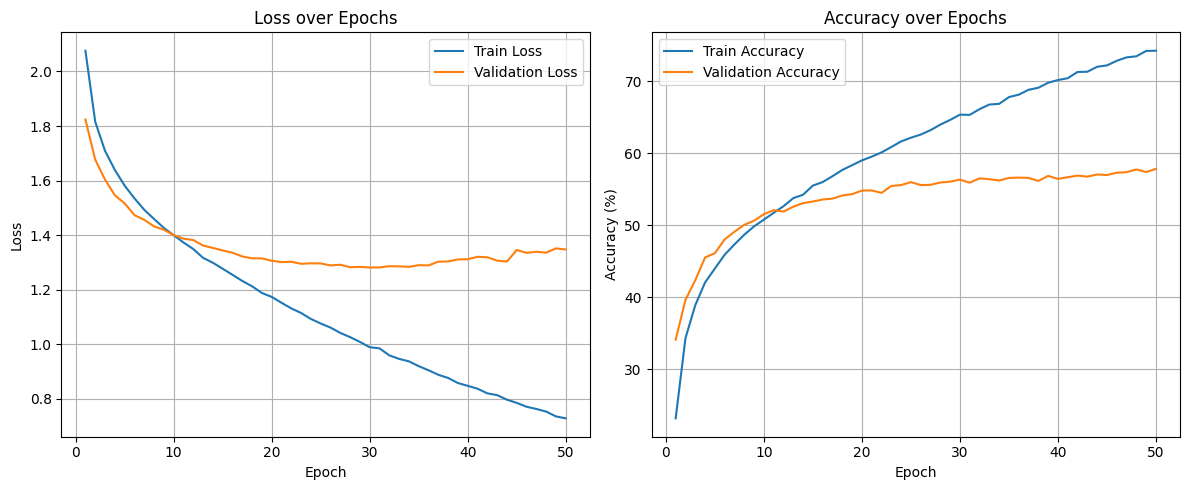

In [15]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_acc'], label='Train Accuracy')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Evaluation

Testing our trained model (using the Test Dataloader that we have). Our goal is to reach an accuracy above `60%` for this section.

In [16]:
test_loss, test_acc = eval_epoch(model, criterion, testloader, test_mode=True)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Test Loss: 1.3329
Test Accuracy: 58.12%


# Convolutional Neural Network

## Model

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

 You are encouraged to learn about the following core components commonly used in convolutional neural networks:

* [`nn.Conv2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
* [`nn.MaxPool2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

**Reminder**: The model we define should contain 33,500,000 ± 500,000 trainable parameters.

In [17]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2,2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2,2)
        )

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(512 * 4 * 4, 3328)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(3328, 512)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)

        self.linear = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.feature_extractor(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        features = self.fc2(x)
        x = self.relu2(features)
        x = self.dropout2(x)

        out = self.linear(x)
        return out


## Trainable params

**Layer-by-Layer Parameter Count**

Each `Conv2d(in_channels, out_channels, kernel_size)` has:
`in × out × k × k (weights)` + `out (biases)` = `in × out × k² + out`
Each `nn.Linear(in, out)` has:
`in × out (weights)` + `out (biases)` = `in × out + out`


1. **Conv2d(3 → 128, kernel=3)**
   → 3 × 128 × 3×3 + 128 = 3456 + 128 = **3,584**

2. **BatchNorm2d(128)**
   → 128 (γ) + 128 (β) = **256**

3. **Conv2d(128 → 128, kernel=3)**
   → 128 × 128 × 3×3 + 128 = 147,456 + 128 = **147,584**

4. **BatchNorm2d(128)**
   → 128 + 128 = **256**

5. **Conv2d(128 → 256, kernel=3)**
   → 128 × 256 × 3×3 + 256 = 294,912 + 256 = **295,168**

6. **BatchNorm2d(256)**
   → 256 + 256 = **512**

7. **Conv2d(256 → 256, kernel=3)**
   → 256 × 256 × 3×3 + 256 = 589,824 + 256 = **590,080**

8. **BatchNorm2d(256)**
   → 256 + 256 = **512**

9. **Conv2d(256 → 512, kernel=3)**
   → 256 × 512 × 3×3 + 512 = 1,179,648 + 512 = **1,180,160**

10. **BatchNorm2d(512)**
    → 512 + 512 = **1,024**

11. **Conv2d(512 → 512, kernel=3)**
    → 512 × 512 × 3×3 + 512 = 2,359,296 + 512 = **2,359,808**

12. **BatchNorm2d(512)**
    → 512 + 512 = **1,024**


> **After flatten: input size = 512 × 4 × 4 = 8192**

13. **Linear(8192 → 3328)**
    → 8192 × 3328 + 3328 = 27,262,976 + 3328 = **27,266,304**

14. **Linear(3328 → 512)**
    → 3328 × 512 + 512 = 1,703,936 + 512 = **1,704,448**

15. **Linear(512 → 10)**
    → 512 × 10 + 10 = 5120 + 10 = **5,130**


**Total Parameters:**

**3,584** + **256** + **147,584** + **256** + **295,168** +
**512** + **590,080** + **512** + **1,180,160** + **1,024** +
**2,359,808** + **1,024** + **27,266,304** + **1,704,448** + **5,130**
\= ***33,555,850***


Once you have completed your hand calculation, you can verify your result by running the following cell:

In [18]:
summary(CNN().to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           3,584
              ReLU-2          [-1, 128, 32, 32]               0
       BatchNorm2d-3          [-1, 128, 32, 32]             256
            Conv2d-4          [-1, 128, 32, 32]         147,584
              ReLU-5          [-1, 128, 32, 32]               0
       BatchNorm2d-6          [-1, 128, 32, 32]             256
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 256, 16, 16]         295,168
              ReLU-9          [-1, 256, 16, 16]               0
      BatchNorm2d-10          [-1, 256, 16, 16]             512
           Conv2d-11          [-1, 256, 16, 16]         590,080
             ReLU-12          [-1, 256, 16, 16]               0
      BatchNorm2d-13          [-1, 256, 16, 16]             512
        MaxPool2d-14            [-1, 25

## Train

### Model instantiation

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(num_classes=10).to(device)

### Criterion & Optimizer

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train loop

Train your model

Tasks:
- Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- save train/validation loss and accuracy (of each epoch) in an array for later usage

In [21]:
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, criterion, optimizer, trainloader)
    val_loss, val_acc = eval_epoch(model, criterion, valloader)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"(Epoch {epoch + 1} / {epochs}) train loss:{train_loss: .4f}; train acc:{train_acc: .2f}%; val loss:{val_loss: .4f}; val_acc:{val_acc: .2f}%")

(Epoch 1 / 50) train loss: 1.4030; train acc: 48.68%; val loss: 1.0336; val_acc: 63.02%
(Epoch 2 / 50) train loss: 0.9237; train acc: 67.13%; val loss: 0.8125; val_acc: 71.82%
(Epoch 3 / 50) train loss: 0.6984; train acc: 75.47%; val loss: 0.7130; val_acc: 75.02%
(Epoch 4 / 50) train loss: 0.5349; train acc: 81.33%; val loss: 0.7024; val_acc: 76.32%
(Epoch 5 / 50) train loss: 0.4032; train acc: 86.06%; val loss: 0.6459; val_acc: 78.90%
(Epoch 6 / 50) train loss: 0.2999; train acc: 89.49%; val loss: 0.7250; val_acc: 77.76%
(Epoch 7 / 50) train loss: 0.2353; train acc: 91.84%; val loss: 0.7860; val_acc: 77.70%
(Epoch 8 / 50) train loss: 0.1728; train acc: 94.09%; val loss: 0.8579; val_acc: 78.24%
(Epoch 9 / 50) train loss: 0.1403; train acc: 95.12%; val loss: 0.8701; val_acc: 78.02%
(Epoch 10 / 50) train loss: 0.0927; train acc: 96.82%; val loss: 0.8622; val_acc: 78.64%
(Epoch 11 / 50) train loss: 0.0657; train acc: 97.84%; val loss: 0.7502; val_acc: 80.74%
(Epoch 12 / 50) train loss: 0.

### Save Model

Since changes need to be made to the model later on, it is advisable to save your model to avoid having to retrain it in case of any issues.

In [22]:
torch.save(model.state_dict(), "cnn.pth")

In [23]:
## To load the previously saved model, simply uncomment the code below.
# model.load_state_dict(torch.load('cnn.pth'))

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

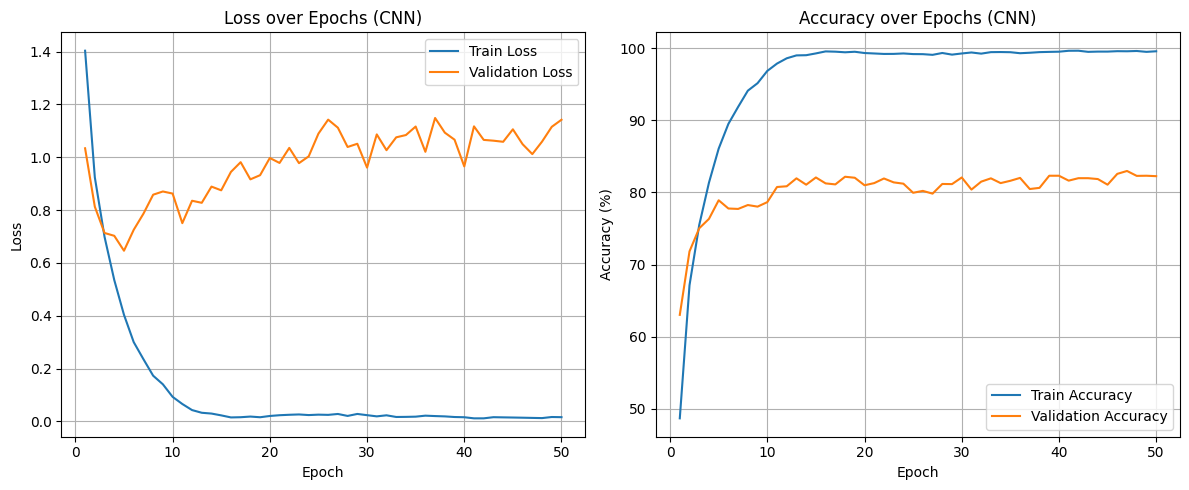

In [24]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss')
plt.plot(epochs_range, history['val_loss'],   label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs (CNN)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_acc'], label='Train Accuracy')
plt.plot(epochs_range, history['val_acc'],   label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs (CNN)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `80%`

In [25]:
test_loss, test_acc = eval_epoch(model, criterion, testloader, test_mode=True)

print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%  (goal: ≥ 80%)")

Test Loss:     1.1933
Test Accuracy: 81.65%  (goal: ≥ 80%)


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model. Note that if you used normalization in the transform function for loading the data, you will need to unnormalize the images before displaying them.

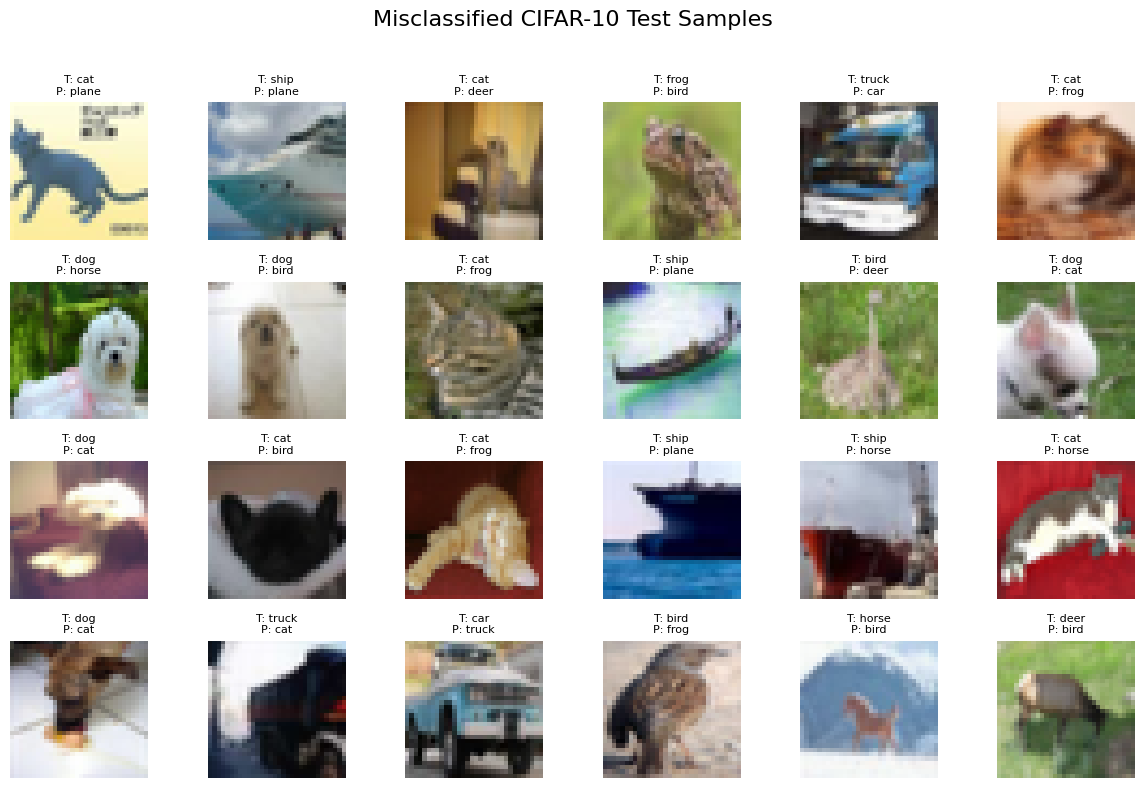

In [26]:
model.eval()

misclassified = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for img, true, pred in zip(inputs.cpu(), labels.cpu(), preds.cpu()):
            if true != pred:
                misclassified.append((norminv(img), true.item(), pred.item()))

samples = random.sample(misclassified, min(24, len(misclassified)))

fig, axes = plt.subplots(4, 6, figsize=(12, 8))
fig.suptitle('Misclassified CIFAR-10 Test Samples', fontsize=16)

for idx, (img, true, pred) in enumerate(samples):
    ax = axes[idx // 6, idx % 6]
    img_np = img.permute(1, 2, 0).numpy().clip(0, 1)
    ax.imshow(img_np)
    ax.set_title(f"T: {classes[true]}\nP: {classes[pred]}", fontsize=8)
    ax.axis('off')

for idx in range(len(samples), 24):
    axes[idx // 6, idx % 6].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('misclassified_samples.png')

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(45000, N)` saved in a variable (for later usage)

- **Hint:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [27]:
trainloader = DataLoader(trainloader.dataset, batch_size=trainloader.batch_size, shuffle=False, num_workers=trainloader.num_workers)

def get_features(model, inputs):
    model.eval()
    with torch.no_grad():
        x = model.feature_extractor(inputs)
        x = model.flatten(x)
        x = model.fc1(x)
        x = model.relu1(x)
        x = model.dropout1(x)
        features = model.fc2(x)
    return features

feature_space = []
train_images = []
train_labels = []

with torch.no_grad():
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        features = get_features(model, inputs)
        feature_space.append(features.cpu())
        train_images.append(inputs.cpu())
        train_labels.append(labels.cpu())

feature_space = torch.cat(feature_space, dim=0)
train_images = torch.cat(train_images, dim=0)
train_labels = torch.cat(train_labels, dim=0)

print(f"Extracted train feature space shape: {feature_space.shape}")

Extracted train feature space shape: torch.Size([45000, 512])


### K Nearest Neighbor in feature space

We already have calculated the feature spaces for trainset ($S$) in the previous section. Now we follow these steps to explore the featre space:

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

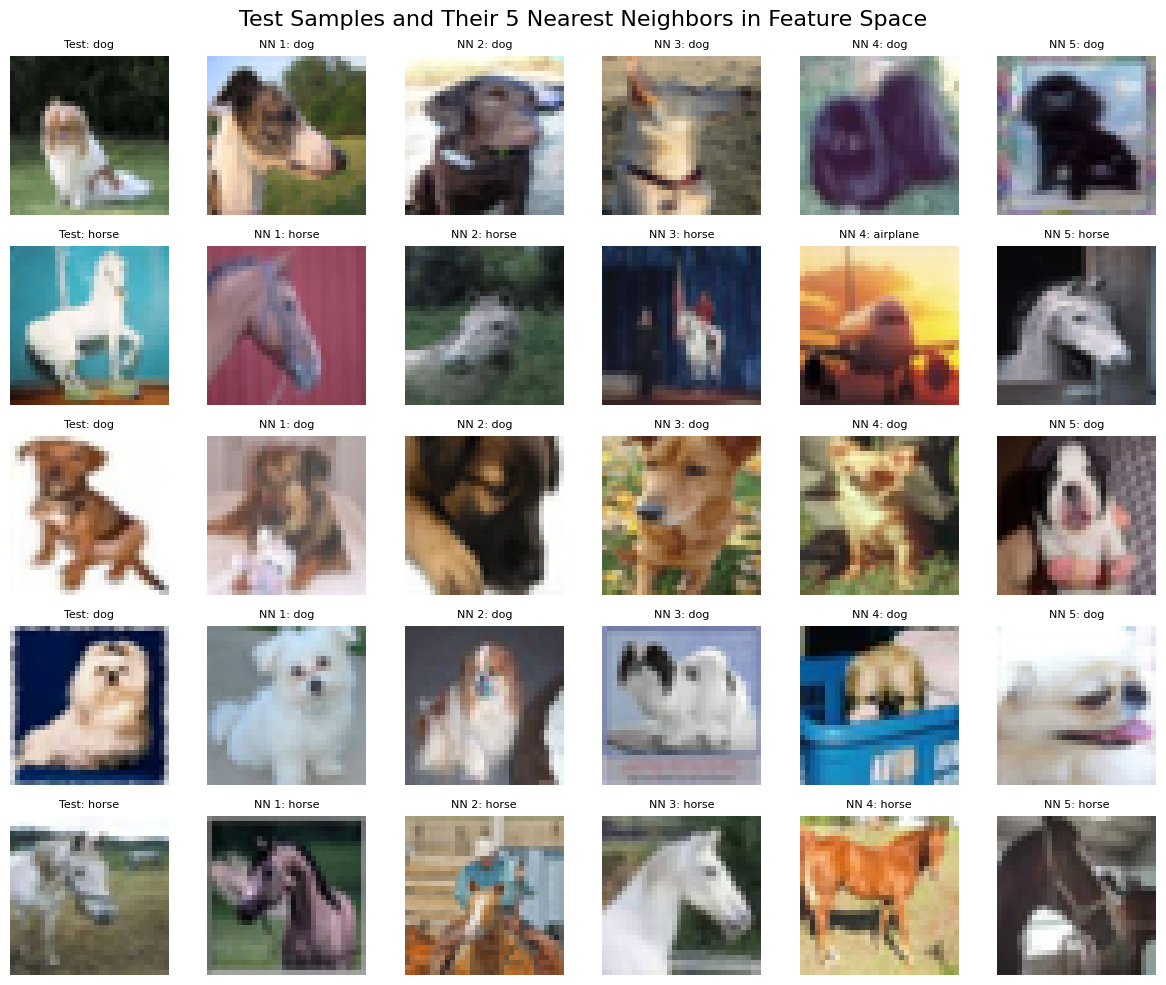

In [28]:
from sklearn.neighbors import NearestNeighbors
random.seed(42)

classes = testloader.dataset.classes

correct_samples = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for i in range(inputs.size(0)):
            if preds[i] == labels[i]:
                correct_samples.append((inputs[i].cpu(), labels[i].cpu().item()))

selected_samples = random.sample(correct_samples, min(5, len(correct_samples)))

knn = NearestNeighbors(n_neighbors=5, metric='euclidean')
knn.fit(feature_space.numpy())

fig, axes = plt.subplots(5, 6, figsize=(12, 10))
fig.suptitle('Test Samples and Their 5 Nearest Neighbors in Feature Space', fontsize=16)

for idx, (img, true_label) in enumerate(selected_samples):
    img_tensor = img.unsqueeze(0).to(device)
    test_feature = get_features(model, img_tensor).cpu().numpy()

    _, indices = knn.kneighbors(test_feature)

    ax = axes[idx, 0]
    img_unnorm = norminv(img.clone())
    img_np = img_unnorm.permute(1, 2, 0).numpy().clip(0, 1)
    ax.imshow(img_np)
    ax.set_title(f"Test: {classes[true_label]}", fontsize=8)
    ax.axis('off')

    for j, n_idx in enumerate(indices[0]):
        ax = axes[idx, j + 1]
        neighbor_img = train_images[n_idx]
        neighbor_label = train_labels[n_idx].item()
        neighbor_img_unnorm = norminv(neighbor_img.clone())
        neighbor_np = neighbor_img_unnorm.permute(1, 2, 0).numpy().clip(0, 1)
        ax.imshow(neighbor_np)
        ax.set_title(f"NN {j+1}: {classes[neighbor_label]}", fontsize=8)
        ax.axis('off')

plt.tight_layout()
plt.savefig("test_samples_nearest_neighbors.png")
plt.show()


We selected 5 correctly classified test samples and found their 5 nearest neighbors from the training set in the feature space.


* The test images and their neighbors had **similar objects** (same class or shape).
* Some similarities were **semantic** (e.g., pose, texture) more than exact visual match.

> Why?

  * The CNN maps similar concepts close together in feature space.
  * This shows that the model learns **meaningful features**, not just pixel-level info.


### TSNE

Let's follow these steps to explore feature space even more:

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now we have a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now we have a vector of size `(M, 2)`)
4. Visualize the points in a 2D plane (Set color of each point based on it's class)


In [29]:
from sklearn.manifold import TSNE

indices = np.random.randint(0, len(feature_space), 2000)
feature_space = feature_space[indices]
tsne = TSNE(n_components=2, random_state=42)
reduced_space = tsne.fit_transform(feature_space.reshape(feature_space.shape[0], -1).detach().cpu().numpy())

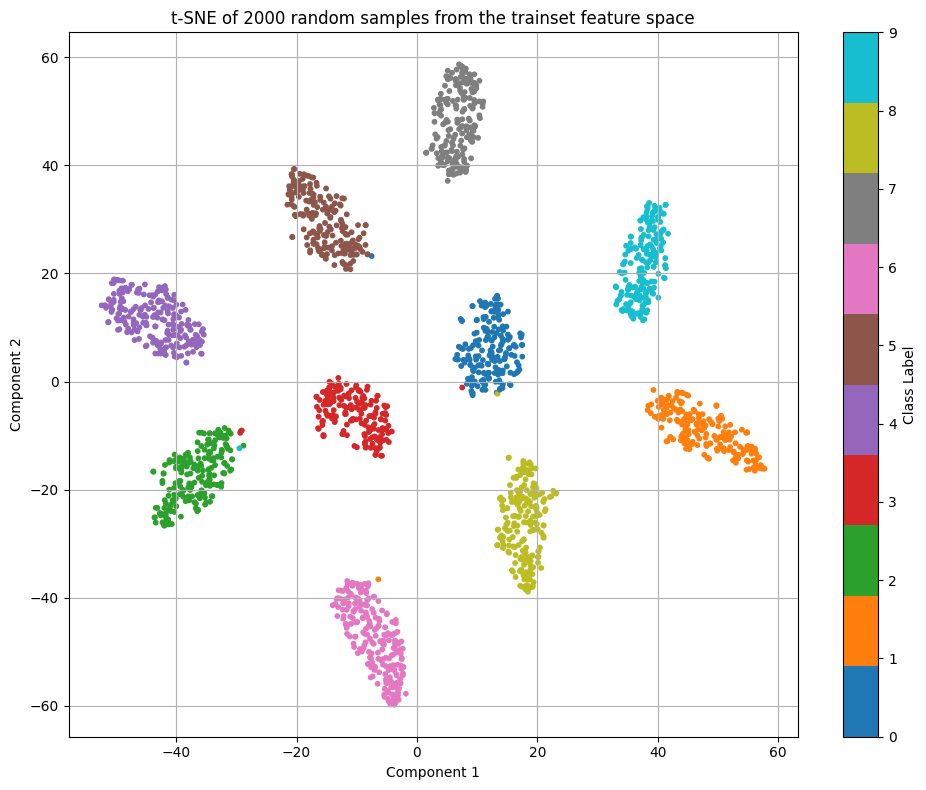

In [30]:
sampled_labels = train_labels[indices]

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    reduced_space[:, 0], reduced_space[:, 1],
    c=sampled_labels.numpy(), cmap='tab10', s=10
)
plt.colorbar(scatter, ticks=range(10), label='Class Label')
plt.title("t-SNE of 2000 random samples from the trainset feature space")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.tight_layout()
plt.savefig("tsne_feature_space.png")
plt.show()


#### Feature Space and Data Clustering Analysis

Using the t-SNE algorithm, 2000 random samples from the model’s feature space were selected and reduced to 2 dimensions. These points were then visualized in a 2D plane, with each point colored based on its class label.

##### Observations:

* The data forms **distinct clusters** in the 2D feature space.
* Most classes tend to occupy **separate regions**, although some overlapping can be observed between similar classes (e.g., cat and dog).
* This clustering behavior suggests that the model has **successfully learned meaningful features** that distinguish between different classes.




### Feature Map


In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's select a random image from dataset.

In [31]:
image = trainset[3][0]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
image = image.to(device)

image = image.unsqueeze(0)

Now, we are going to *clip* our model at different points to get different intermediate representation.
* Clip your model at least at one point and plot the filters output. You can use the output of first Resnet block.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 2 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:2])
)
intermediate_output = clipped(input)
```



In [32]:
import torch.nn as nn

clipped = nn.Sequential(
    *list(model.feature_extractor.children())[:4]
)

model.eval()
with torch.no_grad():
    intermediate_output = clipped(image)


In [33]:
intermediate_output.shape

torch.Size([1, 128, 32, 32])

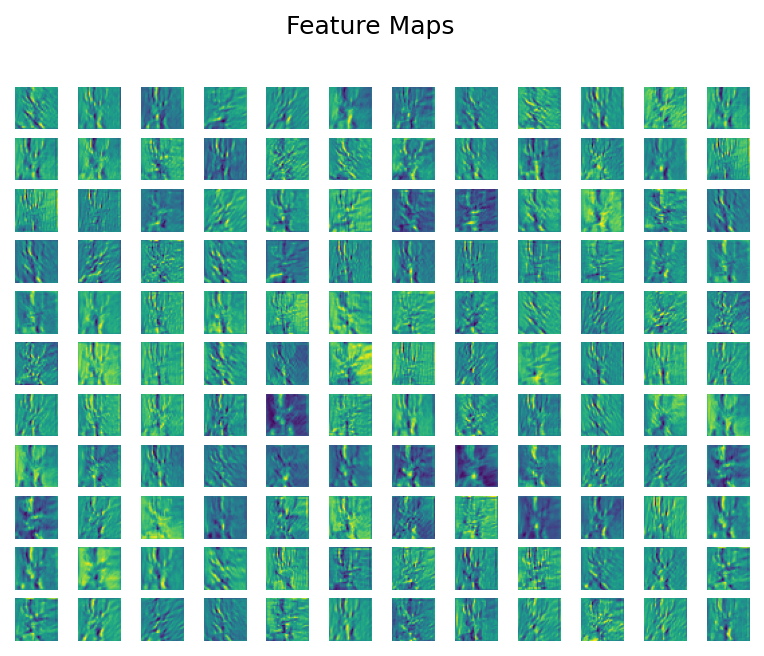

In [34]:
def plot_intermediate_output(result, title=None):
    """
    Plots the intermediate output of shape
    N_FILTERS x H x W
    """
    plt.rcParams['figure.dpi'] = 150
    n_filters = result.shape[1]
    N = int(math.sqrt(n_filters))
    M = (n_filters + N - 1) // N
    assert N * M >= n_filters

    fig, axs = plt.subplots(N, M)
    fig.suptitle(title)

    for i in range(N):
        for j in range(M):
            if i*N + j < n_filters:
                axs[i][j].imshow(result[0, i*N + j].cpu().detach())
                axs[i][j].axis('off')

plot_intermediate_output(intermediate_output, title='Feature Maps')